In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression, mutual_info_regression
from statsmodels.tsa.api import VAR, DynamicVAR

C:\Users\soloc\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
energydata = pd.DataFrame.from_csv('./energydata_complete.csv', index_col=None, encoding="utf-8")
energydata["date"] = pd.to_datetime(energydata.date)
energydata["consumedE"] = energydata["Appliances"]+energydata["lights"]
energydata = energydata[(energydata.date>=pd.to_datetime("2016-01-12")) & (energydata.date<pd.to_datetime("2016-05-27"))]
#energydata.head()

In [3]:
energydata.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,consumedE
count,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,...,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000
mean,97.396344,3.763276,21.673039,40.212379,20.319462,40.394346,22.245344,39.219290,20.837798,38.983193,...,41.518732,7.360404,755.564782,79.760442,4.046492,38.279437,3.712474,24.983413,24.983413,101.159620
std,102.276678,7.842493,1.597255,3.954105,2.176298,4.070266,1.977770,3.248381,2.030943,4.325417,...,4.149146,5.279851,7.367592,14.917120,2.453617,11.756823,4.161938,14.500737,14.500737,104.114204
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,10.000000
25%,50.000000,0.000000,20.730000,37.326667,18.790000,37.863333,20.790000,36.884286,19.500000,35.500000,...,38.500000,3.633333,750.933333,70.333333,2.000000,29.000000,0.900000,12.486373,12.486373,50.000000
50%,60.000000,0.000000,21.600000,39.590000,20.000000,40.466667,22.100000,38.500000,20.633333,38.400000,...,40.837857,6.900000,756.116667,83.666667,3.666667,40.000000,3.400000,24.891900,24.891900,60.000000
75%,100.000000,0.000000,22.600000,42.966667,21.500000,43.210714,23.290000,41.730000,22.100000,42.030000,...,44.252071,10.350000,761.000000,91.666667,5.500000,40.000000,6.500000,37.586778,37.586778,100.000000
max,1080.000000,50.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1110.000000


Now I will group the data by days and i will remove the non correlated features.

# Change in granularity

In [4]:
dfdate = energydata.groupby(energydata.date.dt.date).mean()

In [5]:
dfdate = dfdate.drop(["Appliances","lights"], axis = 1)

# Dickey-Fuller Test

In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries,counts):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=counts)
    rolstd = pd.rolling_std(timeseries, window=counts)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\Users\soloc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  
C:\Users\soloc\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  import sys


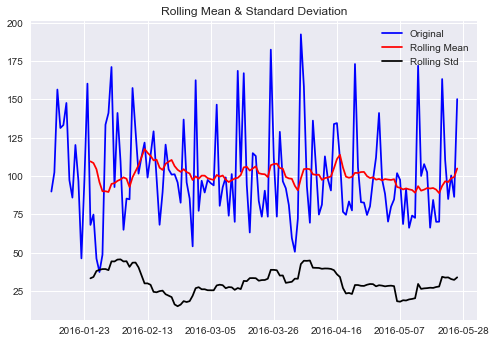

Results of Dickey-Fuller Test:
Test Statistic                -7.677279e+00
p-value                        1.536850e-11
#Lags Used                     2.000000e+00
Number of Observations Used    1.330000e+02
Critical Value (1%)           -3.480500e+00
Critical Value (5%)           -2.883528e+00
Critical Value (10%)          -2.578496e+00
dtype: float64


In [23]:
test_stationarity(dfdate.consumedE,14)

# Feature Reduction
## mutual_info

In [9]:
midate = mutual_info_regression(dfdate.loc[:, dfdate.columns != 'consumedE'], dfdate.consumedE)
midate /= np.max(midate)

In [10]:
mean_midate = sum(midate)/len(midate)
mean_midate

0.20589163360466647

In [11]:
midatefeatures = pd.DataFrame(list(zip(dfdate.loc[:, dfdate.columns != 'consumedE'], midate)), columns = ["name", 'miCoefficient'])
midatefeatures[midatefeatures.miCoefficient > mean_midate]

,name,miCoefficient
0,T1,0.675522
4,T3,0.852450
5,RH_3,0.237292
8,T5,0.287752
14,T8,1.000000
17,RH_9,0.428539
20,RH_out,0.743522
21,Windspeed,0.457630


In [12]:
midatefeatures = midatefeatures[midatefeatures.miCoefficient < mean_midate]
dfdate = dfdate.drop(list(midatefeatures.name.values), axis = 1)

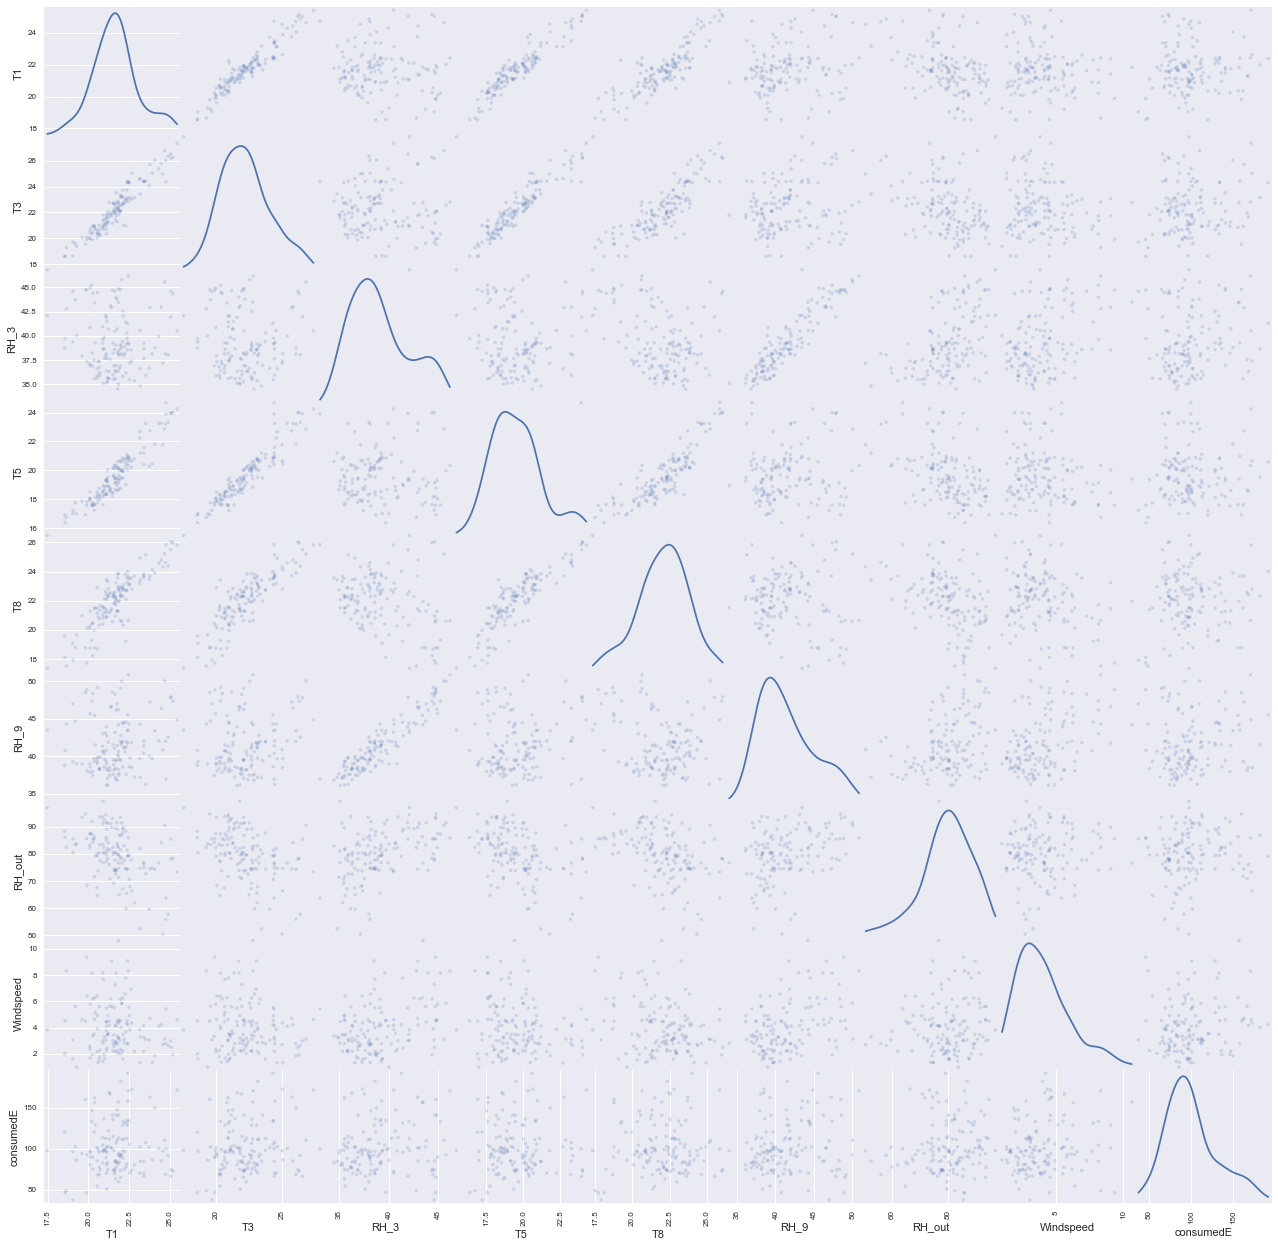

In [13]:
axs = scatter_matrix(dfdate, alpha=0.2, diagonal='kde',figsize=(22,22))

In [14]:
dfdate.head()

,T1,T3,RH_3,T5,T8,RH_9,RH_out,Windspeed,consumedE
date,,,,,,,,,
2016-01-12,20.092326,19.993646,44.933171,18.011939,18.753033,45.680127,87.500000,5.784722,89.930556
2016-01-13,19.197824,19.609213,43.720891,17.755966,18.788722,44.691476,83.406250,5.614583,102.430556
2016-01-14,20.372078,20.837581,43.399740,17.610995,18.769959,45.428229,86.420139,6.277778,156.388889
2016-01-15,22.280949,20.959074,41.409884,19.026125,19.225237,44.534329,88.385417,7.770833,131.319444
2016-01-16,22.119062,21.022170,42.027425,19.454545,20.334724,44.383391,89.649306,3.482639,133.263889


In [15]:
dfdate.min()

T1           17.474103
T3           17.582789
RH_3         33.087534
T5           15.480710
T8           17.362951
RH_9         33.983455
RH_out       50.468750
Windspeed     1.000000
consumedE    37.500000
dtype: float64

In [16]:
data = dfdate# 1. Dickey-Fuller Test.diff(7).dropna() #np.log(dfdate).diff(7).dropna()

In [108]:
max_lag = 15
errorvalue = np.zeros((max_lag-1,2))

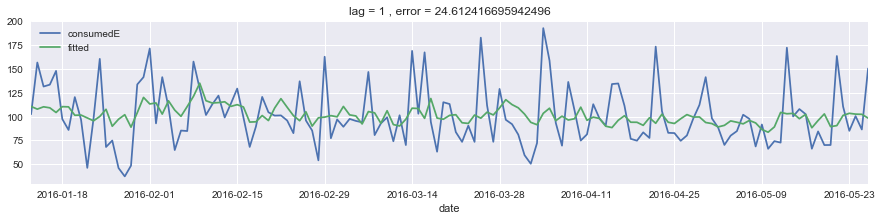

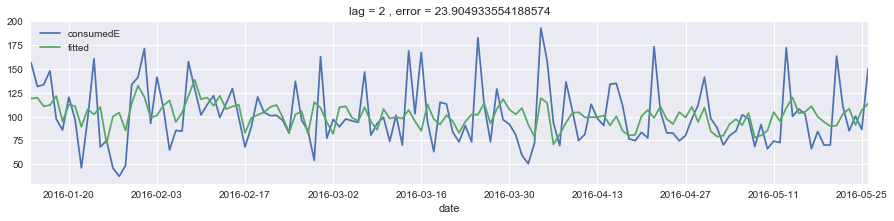

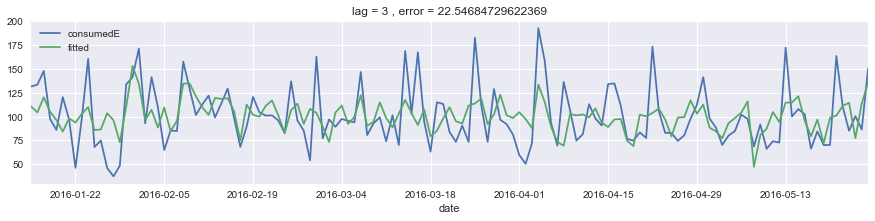

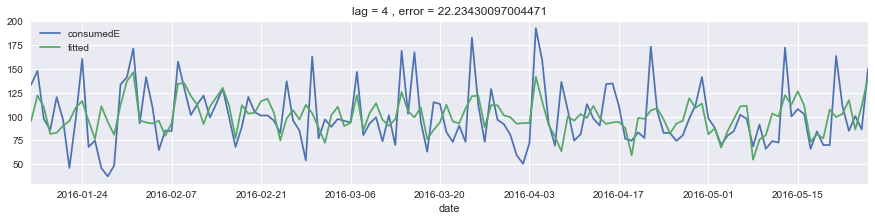

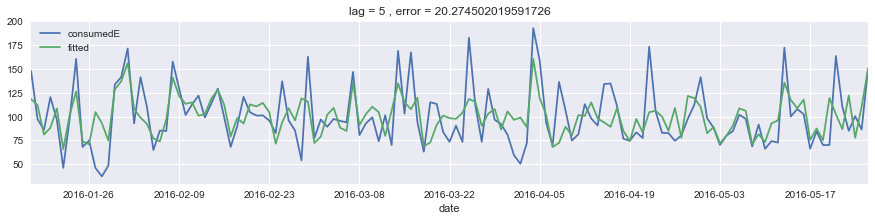

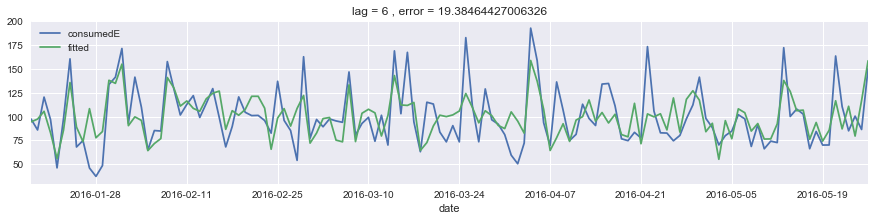

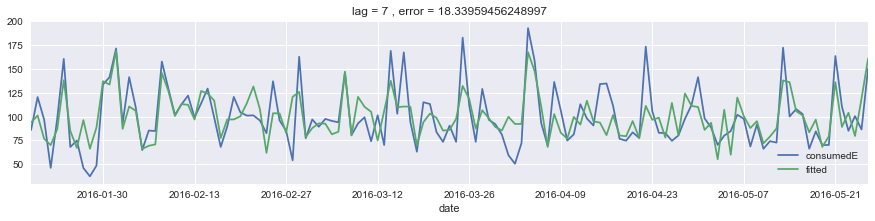

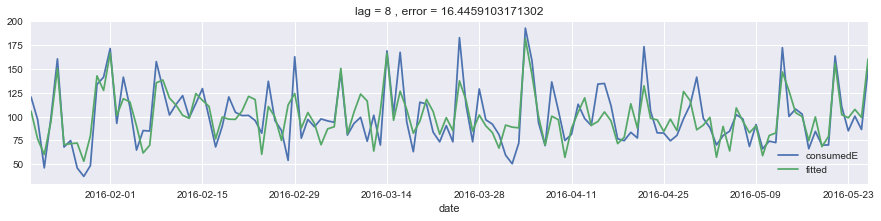

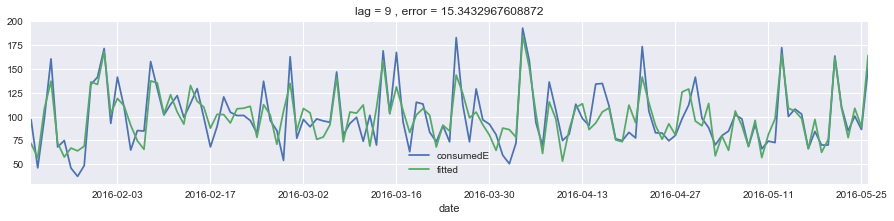

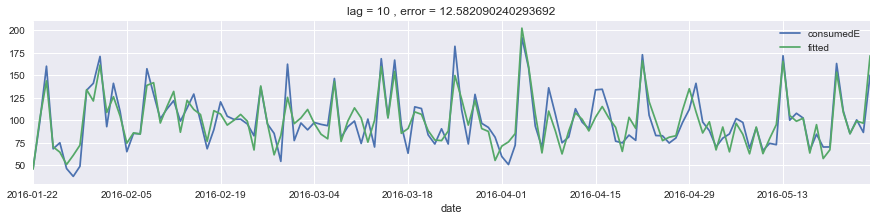

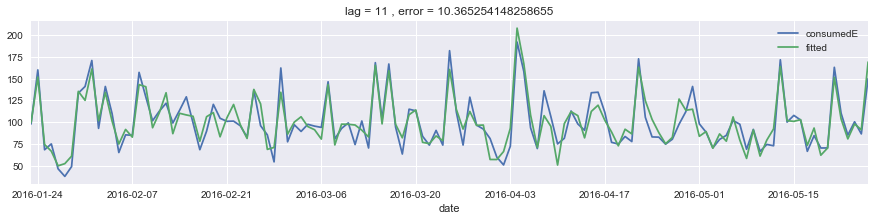

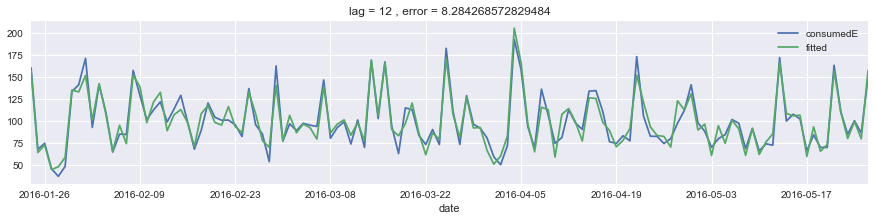

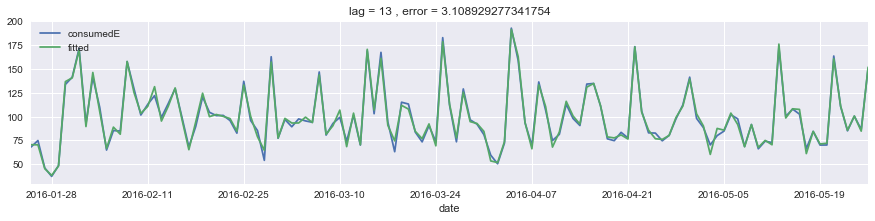

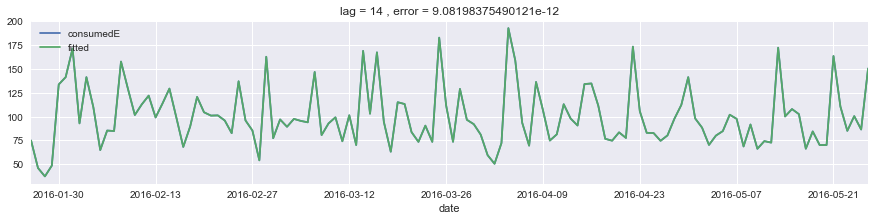

In [114]:
for i in range(1,max_lag):
    model = VAR(dfdate)
    results = model.fit(i)
    final = pd.DataFrame(dfdate.consumedE)
    final["fitted"] = results.fittedvalues.consumedE
    final = final.dropna()
    final["error"] = np.abs(final.fitted - final.consumedE)/final.consumedE
    errorvalue[i-1,0] = int(i)
    errorvalue[i-1,1] = final.error.mean()*100

    df=pd.DataFrame(dfdate.consumedE)
    df["fitted"]=results.fittedvalues.consumedE
    df = df.dropna()
    df[["consumedE","fitted"]].plot(figsize=(15, 3),title="lag = %s , error = %s"%(i,final.error.mean()*100))

In [82]:
#results.summary()

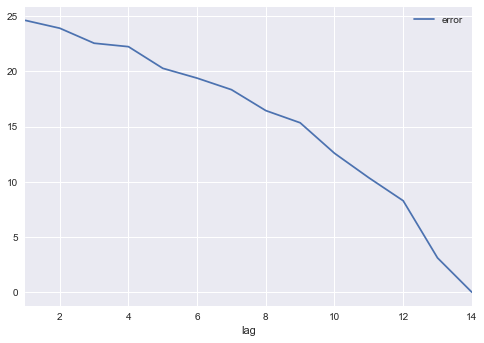

In [115]:
errorplt = pd.DataFrame(errorvalue,columns=["lag","error"])
errorplt = errorplt.set_index("lag")
errorplt.plot()

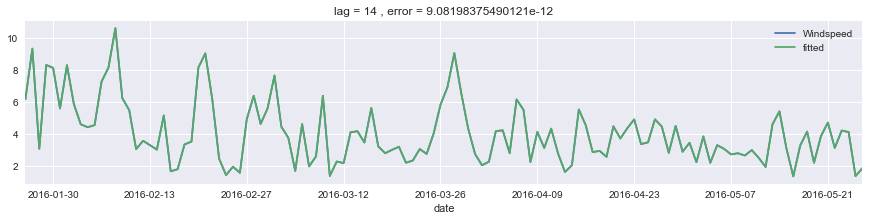

In [116]:
df1=pd.DataFrame(dfdate.Windspeed)
df1["fitted"]=results.fittedvalues.Windspeed
df1 = df1.dropna()
df1[["Windspeed","fitted"]].plot(figsize=(15, 3),title="lag = %s , error = %s"%(i,final.error.mean()*100))